In [1]:
import pandas as pd
import numpy as np
import mailbox
import os
import re
from sklearn.utils import shuffle
from urllib.parse import urlparse
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from gazpacho import Soup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

# 1 Создание таблицы с фишинговыми и обычными email-сообщениями
## 1.1 Загрузка обычных сообщений 

In [2]:
directory = 'easy_ham'
files = sorted(os.listdir(directory))
hum = mailbox.mbox(f'{directory}/{files[0]}')

for file in files[1:]:
    with open(f'{directory}/{file}', 'rb') as f:
        mbox = mailbox.mboxMessage(f)
        hum.add(mbox)
        
directory = 'ham'
files = sorted(os.listdir(directory))
for file in files[1:]:
    with open(f'{directory}/{file}', 'rb') as f:
        mbox = mailbox.mboxMessage(f)
        hum.add(mbox)

In [3]:
len(hum)

6222

## 1.2 Загрузка фишинговых сообщений

In [4]:
phishing1 = mailbox.mbox("phishing1.mbox")
phishing2 = mailbox.mbox("phishing2.mbox")
phishing3 = mailbox.mbox("phishing3.mbox")
phishing4 = mailbox.mbox("phishing4.mbox")
phishing5 = mailbox.mbox("phishing0.mbox")

In [5]:
len(phishing1)+len(phishing2)+len(phishing3)+len(phishing4)+len(phishing5)

4117

## 1.3 Объединение сообщений в одну таблицу


In [6]:
# Функция для создания структуры одного сообщения
def add(messages, phishing):  
    return [{'message': message.get_payload(),
             'from': message['From'],
             'sub': message['Subject'],
             'type': message['Content-Type'],
             'replyto': message.get('Reply-To', 'noone'),
             'phishing': phishing} for message in messages]

In [7]:
# Функция для записи перемешанных данных без пропусков
def write_data(data, filename):
    df = pd.DataFrame(data)
    df = shuffle(df).reset_index(drop=True)
    df.dropna(inplace=True)
    df.to_csv(filename)

In [8]:
df = add(phishing1, 1) + add(hum, 0) + add(phishing2, 1) + add(phishing3, 1) + add(phishing4, 1) + add(phishing5, 1)

In [9]:
# Запись таблицы в файл "df.csv"
write_data(df, 'df.csv')

## 1.4 Считывание таблицы из файла

In [10]:
df = pd.read_csv('df.csv', index_col=0)

In [11]:
len(df.phishing)

6211

In [12]:
df = shuffle(df).reset_index(drop=True)

In [13]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6120 entries, 0 to 6210
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   message   6120 non-null   object
 1   from      6120 non-null   object
 2   sub       6120 non-null   object
 3   type      6120 non-null   object
 4   replyto   6120 non-null   object
 5   phishing  6120 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 334.7+ KB


## 1.5 Лематизация слов в тексте сообщения

In [14]:
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation 
wordnet_lemmatizer = WordNetLemmatizer()

vectorizer = TfidfVectorizer(stop_words=stop_words)

In [15]:
def tokenizer(text):
    tokens = [ word for sent in sent_tokenize(str(text)) for word in word_tokenize(sent)]
    tokens = list(filter(lambda t: t not in punctuation and t.lower() not in stop_words, tokens))
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    filtered_tokens = list(map(lambda token: wordnet_lemmatizer.lemmatize(token.lower()), filtered_tokens))
    filtered_tokens = list(filter(lambda t: t not in punctuation, filtered_tokens))
    return ' '.join(filtered_tokens)

In [16]:
df['clean'] = df.message.map(tokenizer)

# 2 Выделение особенностей
## 2.1 Поиск ссылок в сообщении

In [17]:
# Функция для нахождения всех ссылок (тег) из сообщения
def find_anchors(msg):
    html = Soup(msg.lower())
    a = html.find('a', mode='all')
    
    res = []

    for i in a:
        href = i.attrs.get('href', '')
        text = i.text
        
        res.append(dict(text=text, href=href))
    return res

In [18]:
# Функция для нахождения всех изображений (тег) из сообщения
def find_imgs(msg):
    html = Soup(msg.lower())
    img = html.find('img', mode='all')
    
    res = []

    for i in img:
        src = i.attrs.get('src', '')
        alt = i.attrs.get('alt', '')

        res.append(dict(src=src, alt=alt))
    return res

In [19]:
# Функция для нахождения всех ссылок из сообщения
def find_urls(msg):
    msg = str(msg)
    urls = re.findall(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", msg)
    anchors = [a['href'] for a in find_anchors(msg)]
    return list(set(urls + anchors))

In [20]:
# Функция для получения домена отправителя (после символа @)
def get_email_domain(string):
    domain = re.search("@[\w.]+", string)
    if not domain:
        return None
    return domain[0]

In [21]:
# Функция для получения домена ссылки
def get_url_domain(url):
    domain = None
    if url:
        if '@' in url:
            domain = get_email_domain(str(url))
        else:
            parsed_url = urlparse(url)
            domain = parsed_url.netloc
            if domain[:4] == 'www.':
                return domain[4:]
    return domain

In [22]:
df['links'] = df.message.map(find_urls)
df.head()

,message,from,sub,type,replyto,phishing,clean,links
0,"<font size=""2"" face=""Courier New, Helvetica, s...","""service@paypal.com""<service@paypal.com>",Please restore your account access,"text/html;\n\tcharset=""Windows-1251""",noone,1,font size= face= courier new helvetica sans-se...,[https://www.paypal.com/cgi-bin/webscr.php?cmd...
1,\nBTW: I remember messing about with such thi...,Hal DeVore <haldevore@acm.org>,Re: Ringing bell on other computer,text/plain; charset=us-ascii,exmh-users@example.com,0,btw remember messing thing long ago one proble...,[https://listman.redhat.com/mailman/listinfo/e...
2,<HTML>\n<HEAD>\n<TITLE></TITLE>\n</HEAD>\n<BOD...,"""PayPal"" <service@paypal.com>",Check the status and history of your account,"text/html;\n\tcharset=""Windows-1251""",<do-not-reply@paypal.com>,1,html head title /title /head body p font face=...,"[https://www.paypal.com/</FONT></A><FONT, http..."
3,[<email.message.Message object at 0x7feb86ded9...,"""Paypal Inc."" <acc@paypal.com>",IMPORTANT: Update your PayPal records,"multipart/alternative;\n\tboundary=""--21164709...","""Paypal Inc."" <account@paypal.com>",1,email.message.message object 0x7feb86ded950,[]
4,I agree w/ ya Tom. That kind of thinking is S...,CDale <cdale@techmonkeys.net>,Re: Selling Wedded Bliss (was Re: Ouch...),TEXT/PLAIN; charset=US-ASCII,noone,0,agree w/ ya tom kind thinking idiotic sure gay...,[]


## 2.2 Особенности, связанные с текстом сообщения

In [23]:
# Функция возвращает 1, если в сообщении есть теги, иначе 0
def body_html(t, msg):
    html = Soup(msg.lower())
    h = html.find('html', mode='all')
    return 1 if 'text/html' in t.lower() or h else 0
# Функция возвращает 1, если в сообщении есть тег form, иначе 0
def body_form(msg):
    html = Soup(msg.lower())
    form = html.find('form', mode='all')
    return 1 if form else 0
# Функция возвращает 1, если в сообщении есть J-код, иначе 0
def check_js(msg):
    html = Soup(msg.lower())
    js = html.find('script', mode='all')
    return 1 if js else 0
# Функция для подсчета ключевых слов в тексте сообщения
def body_words(msg):
    num = 0
    wordlist = re.sub('[^A-Za-z]', ' ', msg.strip()).lower().split()
    for word in key_words:
        num += wordlist.count(word)
    return num

In [24]:
key_words = ["account",  "access", "address", "authorized", "bank", "credit", "click", "complete", "here", \
             "identity", "inconvenience", "information", "limited", "link", "log", "login", "minutes", \
             "passcode", "password", "payment", "recently", "risk", "social", "security", "service", \
             "suspended", "theft", "update", "verify"]

In [25]:
df['body_html'] = df.apply(lambda x: body_html(x['type'], x['message']), axis=1)
df['body_form'] =  df.message.map(body_form)
df['js'] =  df['message'].map(check_js)
df['body_words'] = df.clean.map(body_words)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6120 entries, 0 to 6210
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   message     6120 non-null   object
 1   from        6120 non-null   object
 2   sub         6120 non-null   object
 3   type        6120 non-null   object
 4   replyto     6120 non-null   object
 5   phishing    6120 non-null   int64 
 6   clean       6120 non-null   object
 7   links       6120 non-null   object
 8   body_html   6120 non-null   int64 
 9   body_form   6120 non-null   int64 
 10  js          6120 non-null   int64 
 11  body_words  6120 non-null   int64 
dtypes: int64(5), object(7)
memory usage: 621.6+ KB


## 2.3 Особенности в теме сообщения

In [27]:
# Функция возвращает 1, если на сообщение ответили, иначе 0
def subj_reply(subj):
    reply = subj.lower().startswith("re:")
    return int(reply)
# Функция возвращает 1, если сообщение переслано, иначе 0
def subj_forward(subj):
    forward = subj.lower().startswith("fwd:")
    return int(forward)
# Функция для подсчета ключевых слов в тексте сообщения
def subj_words(subj):
    for word in key_words:
        if word in subj:
            return 1
    return 0

In [28]:
df['subj_reply'] =  df['sub'].map(subj_reply)
df['subj_forward'] =  df['sub'].map(subj_forward)
df['subj_words'] =  df['sub'].map(subj_words)
df.head()

,message,from,sub,type,replyto,phishing,clean,links,body_html,body_form,js,body_words,subj_reply,subj_forward,subj_words
0,"<font size=""2"" face=""Courier New, Helvetica, s...","""service@paypal.com""<service@paypal.com>",Please restore your account access,"text/html;\n\tcharset=""Windows-1251""",noone,1,font size= face= courier new helvetica sans-se...,[https://www.paypal.com/cgi-bin/webscr.php?cmd...,1,0,0,45,0,0,1
1,\nBTW: I remember messing about with such thi...,Hal DeVore <haldevore@acm.org>,Re: Ringing bell on other computer,text/plain; charset=us-ascii,exmh-users@example.com,0,btw remember messing thing long ago one proble...,[https://listman.redhat.com/mailman/listinfo/e...,0,0,0,0,1,0,0
2,<HTML>\n<HEAD>\n<TITLE></TITLE>\n</HEAD>\n<BOD...,"""PayPal"" <service@paypal.com>",Check the status and history of your account,"text/html;\n\tcharset=""Windows-1251""",<do-not-reply@paypal.com>,1,html head title /title /head body p font face=...,"[https://www.paypal.com/</FONT></A><FONT, http...",1,0,0,29,0,0,1
3,[<email.message.Message object at 0x7feb86ded9...,"""Paypal Inc."" <acc@paypal.com>",IMPORTANT: Update your PayPal records,"multipart/alternative;\n\tboundary=""--21164709...","""Paypal Inc."" <account@paypal.com>",1,email.message.message object 0x7feb86ded950,[],0,0,0,0,0,0,0
4,I agree w/ ya Tom. That kind of thinking is S...,CDale <cdale@techmonkeys.net>,Re: Selling Wedded Bliss (was Re: Ouch...),TEXT/PLAIN; charset=US-ASCII,noone,0,agree w/ ya tom kind thinking idiotic sure gay...,[],0,0,0,1,1,0,0


## 2.4 Особенности, связанные с отправителем

In [29]:
# Функция проверяет, совпадают ли домен отправителя и домен получателя ответа
def diff_sender_replyto(send, reply):
    send_domain = get_email_domain(send)
    reply_domain = get_email_domain(reply)
    return int(send_domain != reply_domain)
# Функция проверяет, совпадают ли домен отправителя и домены ссылок
def diff_sender_domain(send, urls):
    send_domain = get_email_domain(send)
    for url in urls:
        url_domain = get_url_domain(url)
        if url_domain != send_domain:
            return 1
    return 0

In [30]:
df['diff_sender_replyto'] = df.apply(lambda x: diff_sender_replyto(x['from'], x['replyto']), axis=1)
df['diff_sender_domain'] = df.apply(lambda x: diff_sender_domain(x['from'], x['replyto']), axis=1)

In [31]:
df.head()

,message,from,sub,type,replyto,phishing,clean,links,body_html,body_form,js,body_words,subj_reply,subj_forward,subj_words,diff_sender_replyto,diff_sender_domain
0,"<font size=""2"" face=""Courier New, Helvetica, s...","""service@paypal.com""<service@paypal.com>",Please restore your account access,"text/html;\n\tcharset=""Windows-1251""",noone,1,font size= face= courier new helvetica sans-se...,[https://www.paypal.com/cgi-bin/webscr.php?cmd...,1,0,0,45,0,0,1,1,1
1,\nBTW: I remember messing about with such thi...,Hal DeVore <haldevore@acm.org>,Re: Ringing bell on other computer,text/plain; charset=us-ascii,exmh-users@example.com,0,btw remember messing thing long ago one proble...,[https://listman.redhat.com/mailman/listinfo/e...,0,0,0,0,1,0,0,1,1
2,<HTML>\n<HEAD>\n<TITLE></TITLE>\n</HEAD>\n<BOD...,"""PayPal"" <service@paypal.com>",Check the status and history of your account,"text/html;\n\tcharset=""Windows-1251""",<do-not-reply@paypal.com>,1,html head title /title /head body p font face=...,"[https://www.paypal.com/</FONT></A><FONT, http...",1,0,0,29,0,0,1,0,1
3,[<email.message.Message object at 0x7feb86ded9...,"""Paypal Inc."" <acc@paypal.com>",IMPORTANT: Update your PayPal records,"multipart/alternative;\n\tboundary=""--21164709...","""Paypal Inc."" <account@paypal.com>",1,email.message.message object 0x7feb86ded950,[],0,0,0,0,0,0,0,0,1
4,I agree w/ ya Tom. That kind of thinking is S...,CDale <cdale@techmonkeys.net>,Re: Selling Wedded Bliss (was Re: Ouch...),TEXT/PLAIN; charset=US-ASCII,noone,0,agree w/ ya tom kind thinking idiotic sure gay...,[],0,0,0,1,1,0,0,1,1


## 2.5 Особенности, связанные с ссылками

In [32]:
# Проверка наличия IP в ссылке
def url_IP(links):
    for link in links:
        link = get_url_domain(str(link))
        if re.search(r'\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3}', str(link)):
            return 1
    return 0
# Проверка наличия @ в ссылке
def url_symb(links):
    for link in links:
        if '@' in link:
            return 1
    return 0
# Количество ссылок в сообщении
def url_num(links):
    return len(links)
# Количество уникальных доменов в сообщении
def url_domain(links, sender, reply):
    domains = [get_url_domain(link) for link in links if get_url_domain(link)]
    domains.append(get_email_domain(sender))
    domains.append(get_email_domain(reply))
    return len(set(domains))
# Количество доменов в ссылке
def url_num_domains(links):
    for link in links:
        link = get_url_domain(link)
        if link:
            link = link.split('.')
            if len(link) >= 4:
                return 1
    return 0
# Проверка порта
def url_port(links):
    for link in links:
        if link:
            link = get_url_domain(link)
            if ':' in link:
                port = link[link.find(':') + 1:]
                if port != '80' and port != '443':
                    return 1
    return 0

In [33]:
df['url_IP'] =  df['links'].map(url_IP)
df['url_symb'] =  df['links'].map(url_symb)
df['url_num'] =  df['links'].map(url_num)
df['url_num_domains'] =  df['links'].map(url_num_domains)
df['url_port'] =  df['links'].map(url_port)
df['url_domain'] = df.apply(lambda x: url_domain(x['links'], x['from'], x['replyto']), axis=1)

In [34]:
df.head()

,message,from,sub,type,replyto,phishing,clean,links,body_html,body_form,...,subj_forward,subj_words,diff_sender_replyto,diff_sender_domain,url_IP,url_symb,url_num,url_num_domains,url_port,url_domain
0,"<font size=""2"" face=""Courier New, Helvetica, s...","""service@paypal.com""<service@paypal.com>",Please restore your account access,"text/html;\n\tcharset=""Windows-1251""",noone,1,font size= face= courier new helvetica sans-se...,[https://www.paypal.com/cgi-bin/webscr.php?cmd...,1,0,...,0,1,1,1,1,0,2,1,0,4
1,\nBTW: I remember messing about with such thi...,Hal DeVore <haldevore@acm.org>,Re: Ringing bell on other computer,text/plain; charset=us-ascii,exmh-users@example.com,0,btw remember messing thing long ago one proble...,[https://listman.redhat.com/mailman/listinfo/e...,0,0,...,0,0,1,1,0,0,1,0,0,3
2,<HTML>\n<HEAD>\n<TITLE></TITLE>\n</HEAD>\n<BOD...,"""PayPal"" <service@paypal.com>",Check the status and history of your account,"text/html;\n\tcharset=""Windows-1251""",<do-not-reply@paypal.com>,1,html head title /title /head body p font face=...,"[https://www.paypal.com/</FONT></A><FONT, http...",1,0,...,0,1,0,1,0,0,4,0,0,3
3,[<email.message.Message object at 0x7feb86ded9...,"""Paypal Inc."" <acc@paypal.com>",IMPORTANT: Update your PayPal records,"multipart/alternative;\n\tboundary=""--21164709...","""Paypal Inc."" <account@paypal.com>",1,email.message.message object 0x7feb86ded950,[],0,0,...,0,0,0,1,0,0,0,0,0,1
4,I agree w/ ya Tom. That kind of thinking is S...,CDale <cdale@techmonkeys.net>,Re: Selling Wedded Bliss (was Re: Ouch...),TEXT/PLAIN; charset=US-ASCII,noone,0,agree w/ ya tom kind thinking idiotic sure gay...,[],0,0,...,0,0,1,1,0,0,0,0,0,2


# 3 Выборка

In [35]:
train, test = train_test_split(df[['body_html', 'body_form', 'body_words', 'subj_reply', 'subj_forward', 'subj_words', 'diff_sender_replyto', 'diff_sender_domain', 'url_IP', 'url_symb', 'url_num', 'url_num_domains', 'url_port', 'url_domain', 'js', 'phishing']], test_size=0.2, shuffle=True)

In [36]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [37]:
train_X = train.drop('phishing', axis=1)
train_y = train['phishing']

In [38]:
test_X = test.drop('phishing', axis=1)
test_y = test['phishing']

In [39]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [40]:
train.head(10)

,body_html,body_form,body_words,subj_reply,subj_forward,subj_words,diff_sender_replyto,diff_sender_domain,url_IP,url_symb,url_num,url_num_domains,url_port,url_domain,js,phishing
0,0,0,0,1,0,0,1,1,0,0,0,0,0,2,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,1,0,36,0,0,0,1,1,0,0,4,1,0,4,0,1
3,0,0,0,0,0,0,1,1,0,0,0,0,0,2,0,1
4,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
5,1,0,6,0,0,1,1,1,0,0,4,0,0,5,0,1
6,0,0,0,0,0,0,1,1,0,0,0,0,0,2,0,1
7,0,0,1,1,0,0,1,1,0,0,1,0,0,3,0,0
8,1,0,23,0,0,0,1,1,0,1,52,1,0,10,1,1
9,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1


# 4 Обучение

In [41]:
def metrics(test_y, predict_y, i):
    accuracy = accuracy_score(test_y, predict_y)
    precision = precision_score(test_y, predict_y)
    recall = recall_score(test_y, predict_y)
    f1 = f1_score(test_y, predict_y)
    scores.loc[i] = [accuracy, precision, recall, f1]
    
    print(f'accuracy = {accuracy:.3f}')
    print(f'precision = {precision:.3f}')
    print(f'recall = {recall:.3f}')
    print(f'f1_score = {f1:.3f}')
    print()

## 4.1 Логистическая регрессия

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
scores = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1_score'])

In [44]:
model = LogisticRegression(random_state=42)
model.fit(train_X, train_y)

LogisticRegression(random_state=42)

In [45]:
predict_y = model.predict(test_X)

In [46]:
metrics(test_y, predict_y, 'LogReg')

accuracy = 0.959
precision = 0.958
recall = 0.980
f1_score = 0.969



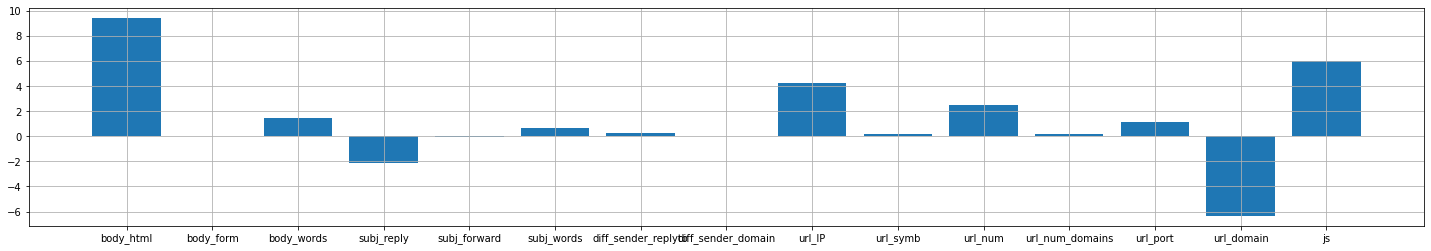

In [47]:
importance = model.coef_[0]
fig, ax = plt.subplots()
ax.bar([x for x in range(len(importance))], importance, tick_label=['body_html', 'body_form', 'body_words', 'subj_reply', 'subj_forward', 'subj_words', 'diff_sender_replyto', 'diff_sender_domain', 'url_IP', 'url_symb', 'url_num', 'url_num_domains', 'url_port', 'url_domain', 'js'])
fig.set_figwidth(25)
plt.grid()
plt.show()

## 4.2 Метод опорных векторов

In [48]:
from sklearn.svm import SVC

In [49]:
%%time
model = SVC(random_state=42)
model.fit(train_X, train_y)

CPU times: user 77.5 ms, sys: 4.31 ms, total: 81.8 ms
Wall time: 81.1 ms


SVC(random_state=42)

In [50]:
predict_y = model.predict(test_X)

In [51]:
metrics(test_y, predict_y, 'SVC')

accuracy = 0.974
precision = 0.979
recall = 0.981
f1_score = 0.980



## 4.3 Метод k-ближайших соседей

In [52]:
from sklearn.neighbors import KNeighborsClassifier

In [53]:
%%time
model = KNeighborsClassifier()
model.fit(train_X, train_y)

CPU times: user 24.6 ms, sys: 1.24 ms, total: 25.8 ms
Wall time: 25.1 ms


KNeighborsClassifier()

In [54]:
predict_y = model.predict(test_X)

In [55]:
metrics(test_y, predict_y, 'KNC')

accuracy = 0.976
precision = 0.981
recall = 0.982
f1_score = 0.982



## 4.4 Наивный Баевский классификатор

In [56]:
from sklearn.naive_bayes import GaussianNB

In [57]:
%%time
model = GaussianNB()
model.fit(train_X, train_y)

CPU times: user 2.57 ms, sys: 1.53 ms, total: 4.11 ms
Wall time: 2.67 ms


GaussianNB()

In [58]:
predict_y = model.predict(test_X)

In [59]:
metrics(test_y, predict_y, 'GNB')

accuracy = 0.660
precision = 0.987
recall = 0.482
f1_score = 0.647



## 4.5 Решающие деревья

In [60]:
from sklearn.tree import DecisionTreeClassifier

In [61]:
%%time
model = DecisionTreeClassifier()
model.fit(train_X, train_y)

CPU times: user 3.62 ms, sys: 1.15 ms, total: 4.77 ms
Wall time: 3.56 ms


DecisionTreeClassifier()

In [62]:
predict_y = model.predict(test_X)

In [63]:
metrics(test_y, predict_y, 'DTC')

accuracy = 0.980
precision = 0.982
recall = 0.986
f1_score = 0.984



## 4.6 Градиентный бустинг

In [64]:
from sklearn.ensemble import GradientBoostingClassifier

In [65]:
%%time
model = GradientBoostingClassifier()
model.fit(train_X, train_y)

CPU times: user 209 ms, sys: 2.39 ms, total: 211 ms
Wall time: 210 ms


GradientBoostingClassifier()

In [66]:
predict_y = model.predict(test_X)

In [67]:
metrics(test_y, predict_y, 'GBC')

accuracy = 0.976
precision = 0.984
recall = 0.980
f1_score = 0.982



## 4.7 Случайный лес

In [68]:
from sklearn.ensemble import RandomForestClassifier

In [69]:
%%time
model = RandomForestClassifier()
model.fit(train_X, train_y)

CPU times: user 194 ms, sys: 3.28 ms, total: 197 ms
Wall time: 197 ms


RandomForestClassifier()

In [70]:
predict_y = model.predict(test_X)

In [71]:
metrics(test_y, predict_y, 'RFC')

accuracy = 0.980
precision = 0.982
recall = 0.986
f1_score = 0.984



# 5 Вывод

In [72]:
def plot(scores, title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    for column in scores.columns:
        plt.plot(scores[column], marker='o')
    plt.legend(scores.columns, loc='lower right')
    plt.grid()
    plt.show()

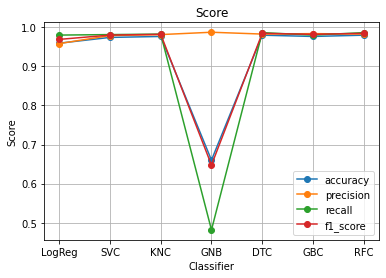

In [73]:
plot(scores, 'Score', 'Classifier', 'Score')